# first GMM APPROACH

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse
import math
import edward as ed
import tensorflow as tf
from matplotlib import pyplot as plt

# import data
* all_sky_star = []: skies
    * all_sky_star[i]: one sky
        * all_sky_star[i][0]: galaxy name
        * all_sky_star[i][1]: galaxy x position
        * all_sky_star[i][2]: galaxy y position
        * all_sky_star[i][3]: galaxy E1
        * all_sky_star[i][4]: galaxy E2
* halo = []:halos
    * halo[i] :halo for sky i
        * halo[i][0]: sky name
        * halo[i][1]: number of halos
        * halo[i][2]: halo1 x
        * halo[i][3]: halo1 y
        * ...
        * halo[i][7]: halo3 y

In [5]:
path = "~/probp.finalproject/datasets"
#path = "~/Developer/probp.finalproject.darkMatter/datasets"
all_sky_star = []
for sky in np.arange(1,301,1):
    sky_path = "Train_Skies/Training_Sky"+str(sky)+".csv"
    halo_path = "Training_halos.csv"
    star = (pd.read_csv(path+"/"+sky_path).values)
    all_sky_star.append(star)
halo = (pd.read_csv(path+"/"+halo_path).values)

In [367]:
#plot e1e2
sky=17
plt.clf()
#plt.scatter(all_sky_star[sky][:,3],all_sky_star[sky][:,4])
print(halo[sky,2],halo[sky,3])
plt.show()

e1,e2 = np.array(all_sky_star[sky][:,3:4],dtype=np.float32),np.array(all_sky_star[sky][:,4:5],dtype=np.float32)
sq = np.sqrt(e1**2+e2**2)
q = ((1.+sq)/(1-sq))**2
a1 = np.sqrt(q/(1+q))
b1 = np.sqrt(1./(1+q))
var_e1 = np.var(all_sky_star[sky][:,3])
var_e2 = np.var(all_sky_star[sky][:,4])
print(var_e1)
print(var_e2)
select = a1/b1>2
select = select.reshape(select.shape[0])
pos_xy = all_sky_star[sky][:,1:3]
num = pos_xy.shape[0]
e1_e2 = all_sky_star[sky][:,3:5]
print(num)

1065.23 3784.81


0.04691703943686513
0.04522027575966948
699


# dist checks

(614,)
(614,)


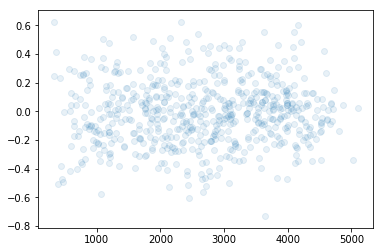

In [257]:
# long/short vs distance
e1,e2 = np.array(all_sky_star[sky][:,3:4],dtype=np.float32),np.array(all_sky_star[sky][:,4:5],dtype=np.float32)
sq = np.sqrt(e1**2+e2**2)
q = ((1.+sq)/(1-sq))**2
a1 = np.sqrt(q/(1+q))
b1 = np.sqrt(1./(1+q))
#print(a1/b1)
gal_x = np.array(all_sky_star[sky][:,1],dtype=np.float32)
gal_y = np.array(all_sky_star[sky][:,2],dtype=np.float32)

l2dist = np.sqrt((gal_x-halo[sky,2])**2+(gal_y-halo[sky,3])**2)
# angle vs angle
#print(l2dist)
plt.scatter(l2dist,e2,alpha=0.1)
print(l2dist.shape)
a_b = (a1/b1).reshape(a1.shape[0])
fun = l2dist*a_b
print(fun.shape)
#plt.hist(fun,100)
plt.show()
#times angle

In [374]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as ds

from edward.models import Normal, Uniform, InverseGamma, Empirical

def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:,1], delta[:,0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

N = num

# Model

X = tf.placeholder(tf.float32, [N, 2])
X_e1 = e1_e2[:,:1].reshape(N).tolist()
X_e2 = e1_e2[:,1:].reshape(N).tolist()

# Xh = Uniform(low=[0.,0.],high=[4200., 4200.])
Xh = Normal(loc=tf.constant([2100., 2100.]), scale=tf.constant(20.0))
# Xh = [2315.61, 1082.86]
m = tf.constant(180.)

sigma = tf.constant(.045) #InverseGamma(20.0, 1.0)

l2diff = tf.sqrt(tf.reduce_sum(tf.square(X - Xh), reduction_indices=1))

sess = ed.get_session()

mu =m / tf.maximum(l2diff, 240.)

print(sess.run(sigma))
e1 = Normal(loc = tf.multiply(tangential(X, Xh, 0), mu), scale = sigma)
e2 = Normal(loc = tf.multiply(tangential(X, Xh, 1), mu), scale = sigma)


0.045


# Model Checks

In [259]:
lz = []
for i in range(N):
    if z[i] < 500:
        print(i,z[i],pos_xy[i])
        lz.append(i)
        
#for t in lz:
#    print('obs:', X_e1[t] / X_e2[t] , sess.run(l2diff, {X:pos_xy})[t])
#    x0 = tangential(X, Xh, 0)
#    y0 = tangential(X, Xh, 1)
#    print('mean:', sess.run(x0, {X:pos_xy})[t] / sess.run(y0, {X:pos_xy})[t])
    
f_x = pos_xy[lz]

TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

# Inference

## Variational Inference

In [267]:
def normal_qx():
    return Normal(tf.minimum(tf.maximum(tf.Variable(tf.random_normal([2], mean=2100.,stddev=500.)),0),4200),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([2], stddev=50.))))

qXh = normal_qx()
inference = ed.KLqp({Xh: qXh}, data={X: pos_xy, e1:X_e1, e2:X_e2})
inference.run(n_iter=10000, n_samples=5)
# X_post = ed.copy(Xh, {Xh: qXh})

    1/10000 [  0%]                                ETA: 89263s | Loss: 111495.750

KeyboardInterrupt: 

## MCMC

In [375]:
# Inference
def constraints_normal(T):
    return tf.minimum(tf.maximum(tf.Variable(tf.random_normal([T, 2], mean=[2100., 2100.],stddev=100.)), 0), 4200)

T = 5000
#qm = Empirical(params=constraints_normal())
qXh = Empirical(params=constraints_normal(T))
#qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
inference = ed.SGHMC({Xh: qXh}, data={X: pos_xy, e1:X_e1, e2:X_e2})
inference.run(step_size=15.)

5000/5000 [100%] ██████████████████████████████ Elapsed: 18s | Acceptance Rate: 1.000


# Criticism

[ 1798.29724121  3328.74389648] [ 190.96720886  509.6262207 ]


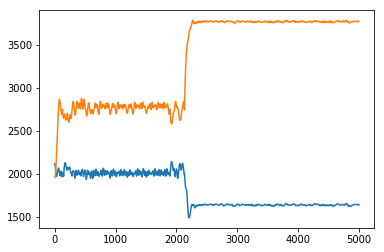

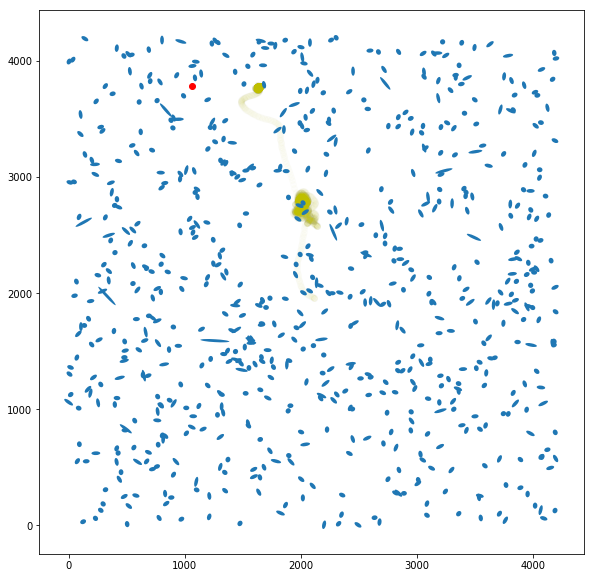

In [373]:
def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i,:]
        x,y = _g[0], _g[1]
        d = np.sqrt( _g[2]**2 + _g[3]**2 )
        a = 1.0/ ( 1 - d )
        b = 1.0/( 1 + d)
        theta = np.degrees( np.arctan2( _g[3], _g[2])*0.5 )
        
        ax.add_patch( Ellipse(xy=(x, y), width=size_multiplier*a, height=size_multiplier*b, angle=theta) )
    ax.autoscale_view(tight=True)
    
    return fig

mean, stddev = sess.run([qXh.mean(), qXh.stddev()])
print(mean, stddev)
samples = sess.run(qXh.params)
#plt.hist(samples, bins='auto')
#plt.show()

# Trace plot.
plt.plot(samples)
plt.show()
plt.clf()
fig = draw_sky(all_sky_star[sky][:,1:])
plt.scatter(samples[:,0], samples[:,1], alpha = 0.015, c = "y")
plt.scatter(halo[sky,2],halo[sky,3], c = "r")
plt.show()

# Example

In [74]:
def mvn_plot_contours(z, label=False, ax=None):
  """Plot the contours of 2-d Normal or MultivariateNormal object.
  Scale the axes to show 3 standard deviations.
  """
  sess = ed.get_session()
  mu = sess.run(z.parameters['loc'])
  mu_x, mu_y = mu
  Sigma = sess.run(z.parameters['scale_tril'])
  sigma_x, sigma_y = np.sqrt(Sigma[0, 0]), np.sqrt(Sigma[1, 1])
  xmin, xmax = mu_x - 3 * sigma_x, mu_x + 3 * sigma_x
  ymin, ymax = mu_y - 3 * sigma_y, mu_y + 3 * sigma_y
  xs = np.linspace(xmin, xmax, num=100)
  ys = np.linspace(ymin, ymax, num=100)
  X, Y = np.meshgrid(xs, ys)
  T = tf.cast(np.c_[X.flatten(), Y.flatten()], dtype=tf.float32)
  Z = sess.run(tf.exp(z.log_prob(T))).reshape((len(xs), len(ys)))
  if ax is None:
    fig, ax = plt.subplots()
  cs = ax.contour(X, Y, Z)
  if label:
    plt.clabel(cs, inline=1, fontsize=10)


ed.set_seed(42)

# MODEL
z = MultivariateNormalTriL(
    loc=tf.ones(2),
    scale_tril=tf.cholesky(tf.constant([[1.0, 0.8], [0.8, 1.0]])))

# INFERENCE
qz = Empirical(params=tf.Variable(tf.random_normal([1000, 2])))

inference = ed.HMC({z: qz})
inference.run()

# CRITICISM
sess = ed.get_session()
mean, stddev = sess.run([qz.mean(), qz.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev:")
print(stddev)

fig, ax = plt.subplots()
trace = sess.run(qz.params)
ax.scatter(trace[:, 0], trace[:, 1], marker=".")
mvn_plot_contours(z, ax=ax)
plt.show()

RuntimeError: Seeding is not supported after initializing part of the graph. Please move set_seed to the beginning of your code.

In [ ]:
a = [1,2,3,4]
print(a)